In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Generalized Function to Load Data

In [3]:
def load_data(folder_path, pattern_prefix):
    """
    Load data from Excel files with flexible naming pattern
    
    Args:
        folder_path: Path to directory containing Excel files
        pattern_prefix: The middle part of the filename (e.g., "Location" or "Scenarios")
                       Files should be named like f"SA_{pattern_prefix}_*.xlsx"
    
    Returns:
        Nested dictionary: {name: {sheet: DataFrame}}
    """
    # Verify the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The directory {folder_path} does not exist")
    
    # Create regex pattern to extract names
    pattern = re.compile(fr'SA_{pattern_prefix}_(.*?)\.xlsx')
    
    # Get all names from filenames
    names = []
    for f in os.listdir(folder_path):
        match = pattern.match(f)
        if match:
            names.append(match.group(1))
    
    # Initialize nested dictionary
    data_dict = {name: {} for name in names}
    
    # Read each file and its sheets
    for name in data_dict.keys():
        filename = f"SA_{pattern_prefix}_{name}.xlsx"
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Read all sheets from the Excel file
            sheets = pd.read_excel(file_path, sheet_name=None)
            
            # Store each sheet (Fold_1 to Fold_5) in the dictionary
            for sheet_num in range(1, 6):
                sheet_name = f"Fold_{sheet_num}"
                if sheet_name in sheets:
                    data_dict[name][sheet_name] = sheets[sheet_name]
                else:
                    print(f"Warning: Sheet {sheet_name} not found in {filename}")
                    
        except FileNotFoundError:
            print(f"Warning: File {filename} not found in {folder_path}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    return data_dict

## Generalized Function to Stacked Algorithm Performance Plot

In [4]:
def prepare_stacked_data(data, fields):
    stacked_data = []
    
    for field, folds in data.items():
        for algorithm in ['LP', 'SO', 'RO']:
            capex_sum = opex_hvac_sum = opex_c_sum = 0
            count = 0
            
            for fold, df in folds.items():
                alg_df = df[df['Algorithm'] == algorithm]
                if not alg_df.empty:
                    capex_sum += alg_df['Training Capital Cost'].mean()
                    opex_hvac_sum += alg_df['Testing HVAC Cost'].mean()
                    opex_c_sum += alg_df['Testing Critical Load Cost'].mean()
                    count += 1
            
            if count > 0:
                stacked_data.append({
                    fields: field,
                    'Algorithm': algorithm,
                    'CaPEX': capex_sum / count,
                    'OPEX HVAC': opex_hvac_sum / count,
                    'OPEX C': opex_c_sum / count,
                    'Total': (capex_sum + opex_hvac_sum + opex_c_sum) / count
                })
    
    return pd.DataFrame(stacked_data)


## Generalized Function to do Capacity Bar Plot

In [5]:
def scenario_capacity_barplot(location_data, SA_name, plot_name, special_scenarios, scenario_order=None):
    """
    Plot average capacities with Alaska and Minnesota on left (individual y-axis),
    and other scenarios with shared y-axis range.
    scenario_order: list of all scenarios in desired order (special_scenarios + others)
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import pandas as pd
    import numpy as np

    # Set IEEE-compliant font and style globally
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 14

    # Prepare data - average across folds
    scenario_avgs = {}
    for scenario, folds in location_data.items():
        all_folds = pd.concat(folds.values())
        scenario_avgs[scenario] = all_folds.groupby('Algorithm')[
            ['PV_Size', 'Battery_Size', 'PCM_Heating_Size', 'PCM_Cooling_Size']
        ].mean().reset_index()

    # Use provided order or default to previous logic
    if scenario_order is not None:
        all_scenarios = [s for s in scenario_order if s in scenario_avgs]
    else:
        other_scenarios = [s for s in sorted(scenario_avgs.keys()) if s not in special_scenarios]
        all_scenarios = special_scenarios + other_scenarios

    n_scenarios = len(all_scenarios)
    fig_width = min(6 * n_scenarios, 24)  # Cap width at 24 inches
    fig = plt.figure(figsize=(fig_width, 6))

    # Create grid spec with dynamic columns
    gs = fig.add_gridspec(1, n_scenarios, width_ratios=[1]*n_scenarios, wspace=0.3)

    # Define appliance properties
    appliances = {
        'PV_Size': {'color': '#FFD700', 'label': 'PV'},
        'Battery_Size': {'color': '#32CD32', 'label': 'Battery'},
        'PCM_Heating_Size': {'color': '#FF6347', 'label': 'PCM Heat'},
        'PCM_Cooling_Size': {'color': '#1E90FF', 'label': 'PCM Cool'}
    }

    # Find global y-limits for "other" scenarios
    if n_scenarios > len(special_scenarios):
        other_data = pd.concat([scenario_avgs[s] for s in all_scenarios[len(special_scenarios):]])
        y_min = other_data[list(appliances.keys())].min().min() * 0.9
        y_max = other_data[list(appliances.keys())].max().max() * 1.1
    else:
        y_min, y_max = None, None

    # Plot each scenario
    for i, scenario in enumerate(all_scenarios):
        ax = fig.add_subplot(gs[0, i])
        data = scenario_avgs[scenario]

        for j, algorithm in enumerate(['LP', 'SO', 'RO']):
            alg_data = data[data['Algorithm'] == algorithm]
            x_pos = j
            offset = 0
            for k, appliance in enumerate(appliances.keys()):
                ax.bar(x_pos + offset, alg_data[appliance].values[0], 0.2,
                       color=appliances[appliance]['color'],
                       label=appliances[appliance]['label'] if j == 0 else "")
                offset += 0.2

        ax.set_title(scenario, fontsize=10, fontweight='bold')
        ax.set_xticks([0.3, 1.3, 2.3])
        ax.set_xticklabels(['LP', 'SO', 'RO'])
        ax.set_xlabel('Algorithm', fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        if i < len(special_scenarios):
            ax.set_ylabel('Average Capacity', fontsize=8)
        else:
            if y_min is not None and y_max is not None:
                ax.set_ylim(y_min, y_max)
            if i == len(special_scenarios):
                ax.set_ylabel('Average Capacity', fontsize=8)
            else:
                ax.set_ylabel('')

    # Create unified legend (centered at the top, under suptitle)
    handles = [plt.Rectangle((0,0),1,1, color=props['color']) 
               for props in appliances.values()]
    labels = [props['label'] for props in appliances.values()]
    fig.legend(handles, labels, 
               title='Component', loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=4, fontsize=8, frameon=False)

    fig.suptitle(f'Average Capacities by Scenario: {plot_name}', y=1.08, fontsize=14, fontweight='bold', fontname='Times New Roman')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

## Locations

In [6]:
def plot_grouped_stacked_bars_ieee_grouped(data, SA_name, plot_name):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl

    # Set IEEE-compliant font and style globally
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 14

    # Prepare data
    stacked_df = prepare_stacked_data(data, SA_name)
    print("Available locations:", stacked_df[SA_name].unique())

    group1 = ['Alaska', 'Minnesota']
    group2 = ['Arizona', 'HalfMoonBay', 'Florida']

    group1 = [loc for loc in group1 if loc in stacked_df[SA_name].unique()]
    group2 = [loc for loc in group2 if loc in stacked_df[SA_name].unique()]

    algorithms = ['LP', 'SO', 'RO']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    plt.subplots_adjust(wspace=0.3)

    width = 0.25

    # --- Group 1: Alaska & Minnesota ---
    ax1 = axes[0]
    x_tick_positions = []
    x_tick_labels = []
    region_tick_positions = []
    region_tick_labels = []
    for i, loc in enumerate(group1):
        loc_df = stacked_df[stacked_df[SA_name] == loc]
        x_pos = np.arange(len(algorithms)) + i * (len(algorithms) + 1)
        bottom = np.zeros(len(algorithms))
        for j, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [loc_df[loc_df['Algorithm'] == alg][category].values[0] for alg in algorithms]
            ax1.bar(x_pos, values, width, bottom=bottom, color=colors[j], edgecolor='black', linewidth=0.8)
            bottom += np.array(values)
        for k, xpos in enumerate(x_pos):
            x_tick_positions.append(xpos)
            x_tick_labels.append(algorithms[k])
        region_tick_positions.append(np.mean(x_pos))
        region_tick_labels.append(loc)
    ax1.set_ylim(0, 17000)
    ax1.set_ylabel('Cost ($)', fontsize=8)
    ax1.set_xticks(x_tick_positions)
    ax1.set_xticklabels(x_tick_labels, fontsize=8)
    # ax1.legend(['CaPEX', 'OPEX HVAC', 'OPEX C'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=8, frameon=False)
    ax1.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    # Region names as a second row of x-tick labels (use axis fraction for y)
    for xpos, label in zip(region_tick_positions, region_tick_labels):
        ax1.text(xpos, -0.10, label, ha='center', va='top', fontsize=8, fontweight='bold',
         transform=ax1.get_xaxis_transform(), clip_on=False)

    # --- Group 2: Arizona, HalfMoonBay, Florida ---
    ax2 = axes[1]
    x_tick_positions = []
    x_tick_labels = []
    region_tick_positions = []
    region_tick_labels = []
    for i, loc in enumerate(group2):
        loc_df = stacked_df[stacked_df[SA_name] == loc]
        x_pos = np.arange(len(algorithms)) + i * (len(algorithms) + 1)
        bottom = np.zeros(len(algorithms))
        for j, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [loc_df[loc_df['Algorithm'] == alg][category].values[0] for alg in algorithms]
            ax2.bar(x_pos, values, width, bottom=bottom, color=colors[j], edgecolor='black', linewidth=0.8)
            bottom += np.array(values)
        for k, xpos in enumerate(x_pos):
            x_tick_positions.append(xpos)
            x_tick_labels.append(algorithms[k])
        region_tick_positions.append(np.mean(x_pos))
        region_tick_labels.append(loc)
    ax2.set_ylim(0, 3200)
    ax2.set_ylabel('Cost ($)', fontsize=8)
    ax2.set_xticks(x_tick_positions)
    ax2.set_xticklabels(x_tick_labels, fontsize=8)
    ax2.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    for xpos, label in zip(region_tick_positions, region_tick_labels):
        ax2.text(xpos, -0.18, label, ha='center', va='top', fontsize=8, fontweight='bold',
                 transform=ax2.get_xaxis_transform(), clip_on=False)

    plt.suptitle(f'Testing Stage Performance of Algorithms with Different {plot_name}', 
             y=1.08, fontsize=14, fontweight='bold', fontname='Times New Roman')
    handles = [mpl.patches.Patch(color=c, label=l) for c, l in zip(colors, ['CaPEX', 'OPEX HVAC', 'OPEX C'])]
    fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=8, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Available locations: ['Alaska' 'Arizona' 'Florida' 'HalfMoonBay' 'Minnesota']


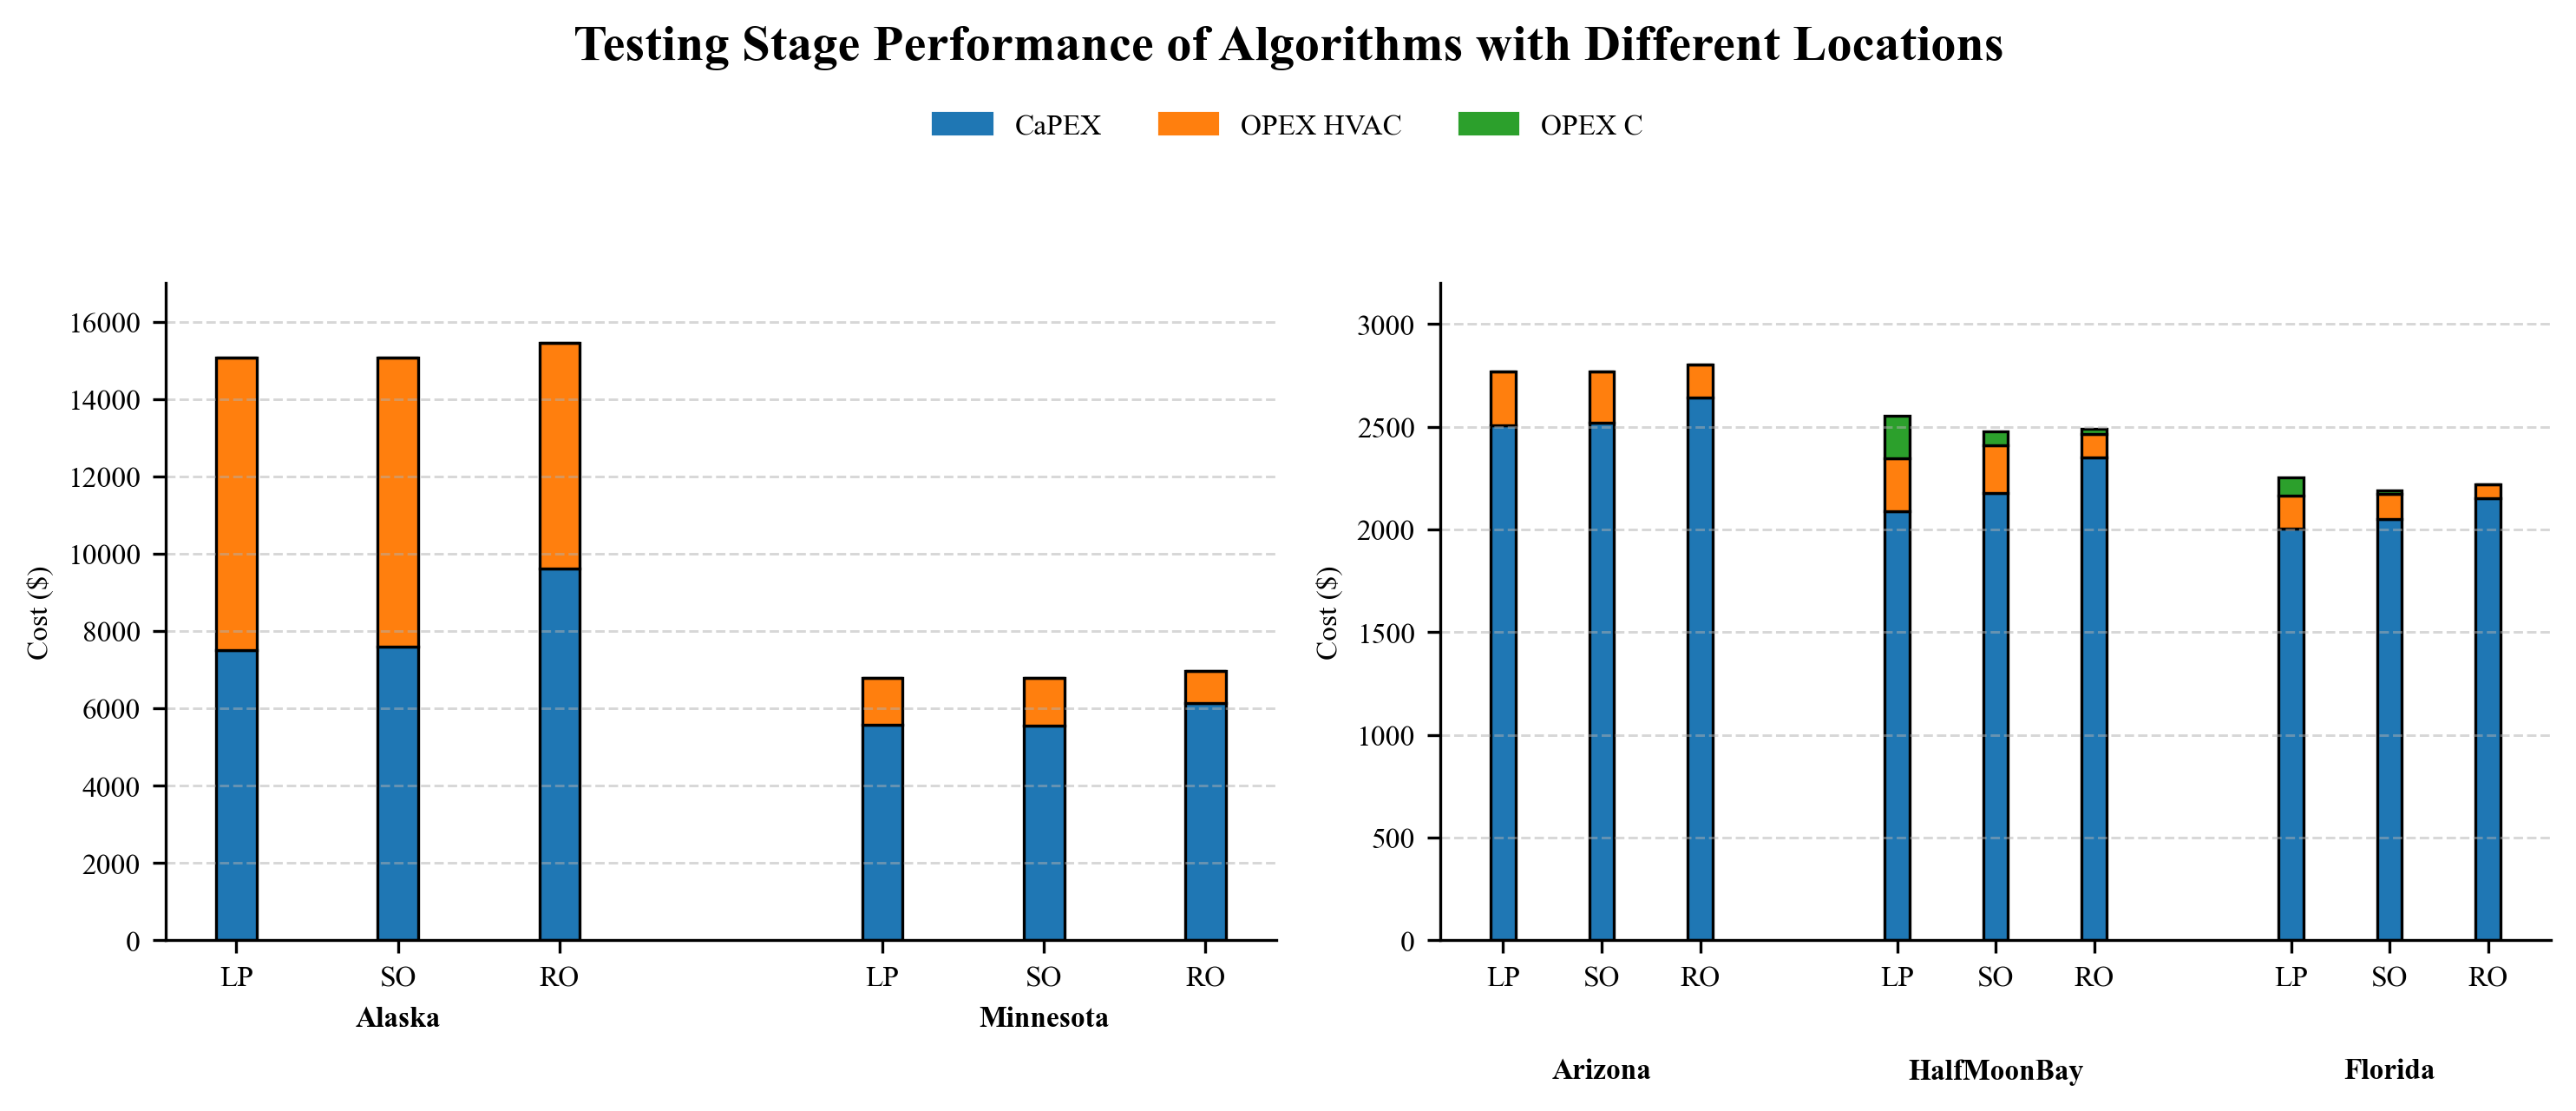

In [7]:
SA_name = 'Locations'

# Example usage for Locations:
location_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars_ieee_grouped(location_data, 'Location', 'Locations')


C:\Users\Fred\AppData\Local\Temp\ipykernel_14124\2231171250.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


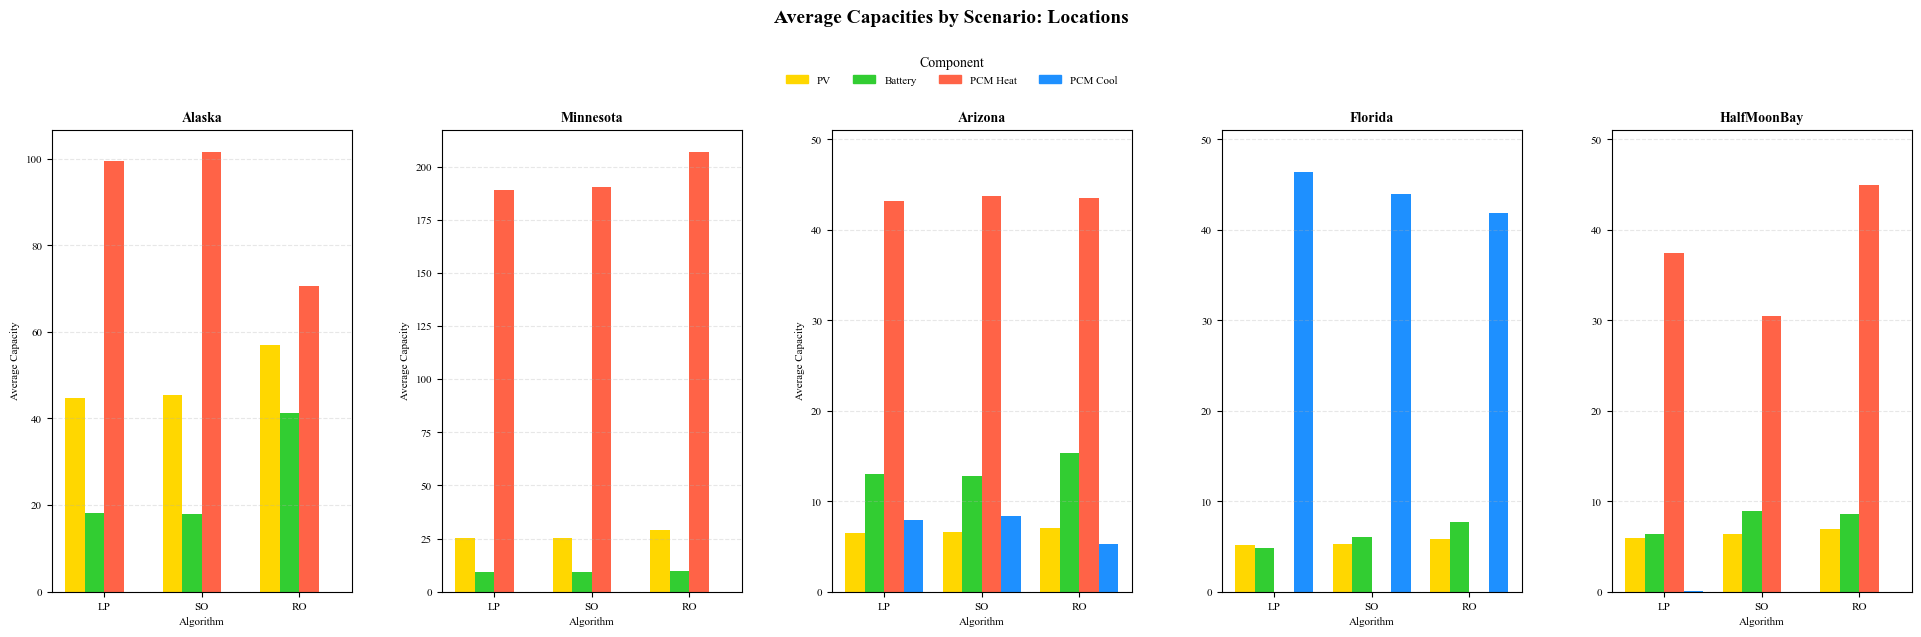

In [8]:

# capacity bar plot
special_scenarios = ['Alaska', 'Minnesota']
scenario_capacity_barplot(location_data, SA_name, "Locations", special_scenarios)

## Scenarios

In [9]:
def plot_grouped_stacked_bars_ieee_applications(data, SA_name, plot_name):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl

    # Set IEEE-compliant font and style globally
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 14

    # Prepare data
    stacked_df = prepare_stacked_data(data, SA_name)
    print("Available applications:", stacked_df[SA_name].unique())

    # Desired order
    desired_order = ['DC', 'RC', 'FOB']
    applications = [app for app in desired_order if app in stacked_df[SA_name].unique()]
    algorithms = ['LP', 'SO', 'RO']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # CaPEX, OPEX HVAC, OPEX C

    fig, axes = plt.subplots(1, len(applications), figsize=(10, 4), dpi=300)
    if len(applications) == 1:
        axes = [axes]  # Ensure axes is always iterable

    width = 0.6

    # For legend handles
    legend_handles = []

    for idx, (ax, app) in enumerate(zip(axes, applications)):
        app_df = stacked_df[stacked_df[SA_name] == app]
        x_pos = np.arange(len(algorithms))
        bottom = np.zeros(len(algorithms))
        bars = []
        for j, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [app_df[app_df['Algorithm'] == alg][category].values[0] for alg in algorithms]
            bar = ax.bar(x_pos, values, width, bottom=bottom, color=colors[j], edgecolor='black', linewidth=0.8, label=category)
            if idx == 0:
                legend_handles.append(bar)
            bottom += np.array(values)
        # X-axis labels
        ax.set_xticks(x_pos)
        ax.set_xticklabels(algorithms, fontsize=8)
        # Application name under the group
        ax.text(np.mean(x_pos), -0.18, app, ha='center', va='top', fontsize=8, fontweight='bold',
                transform=ax.get_xaxis_transform(), clip_on=False)
        ax.set_ylabel('Cost ($)', fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Main title
    plt.suptitle(f'Testing Stage Performance of Algorithms with different {plot_name}', 
                 y=1.08, fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Legend: top center, under suptitle
    fig.legend(['CaPEX', 'OPEX HVAC', 'OPEX C'], loc='upper center', bbox_to_anchor=(0.5, 0.98),
               ncol=3, fontsize=8, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Available applications: ['DC' 'FOB' 'RC']


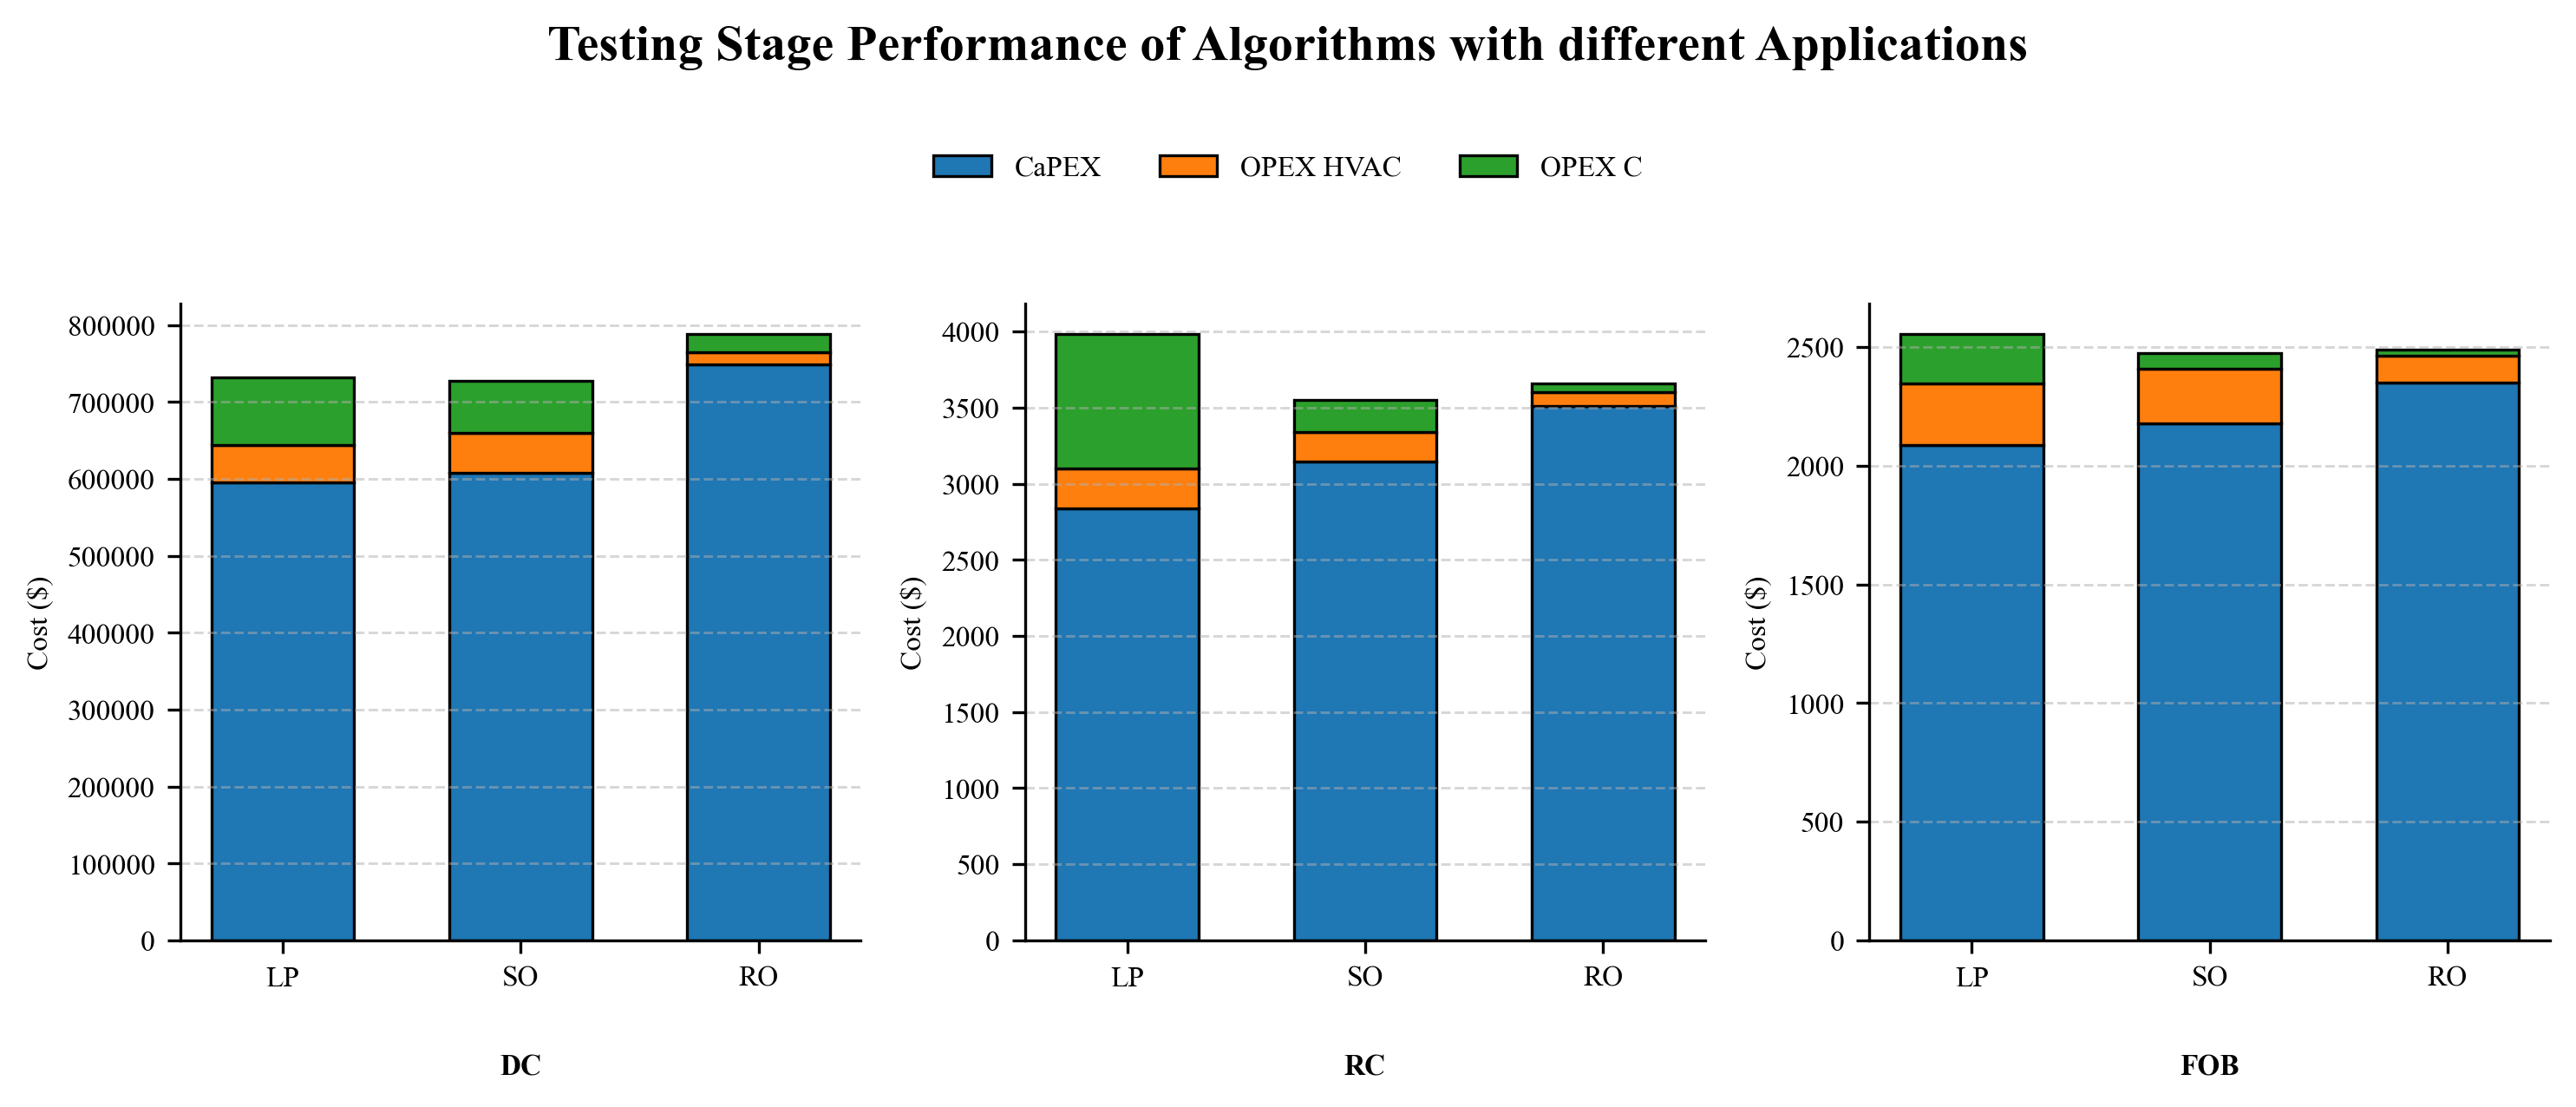

In [10]:
SA_name = 'Scenarios'


scenario_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars_ieee_applications(scenario_data, SA_name, "Applications")

C:\Users\Fred\AppData\Local\Temp\ipykernel_14124\2231171250.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


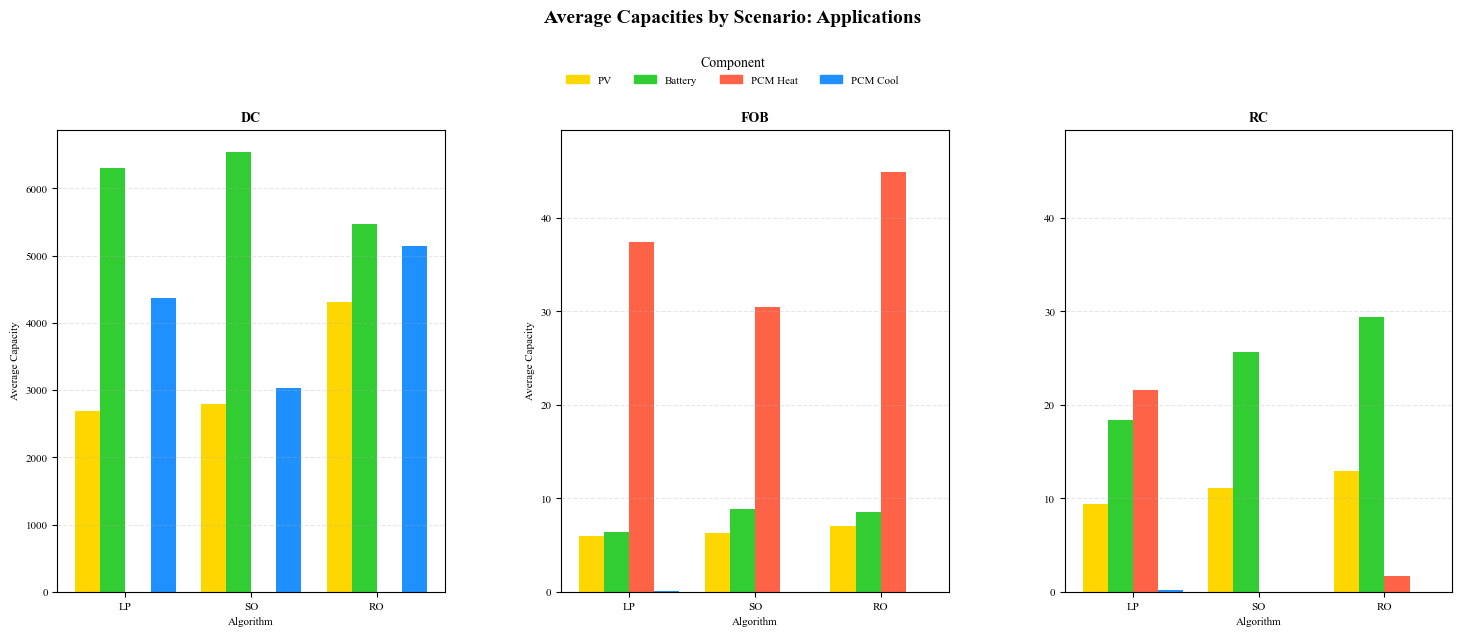

In [11]:
# capacity bar plot

special_scenarios = ['DC']
scenario_capacity_barplot(scenario_data, SA_name, "Applications", special_scenarios)

In [16]:
def plot_grouped_stacked_bars_ieee_cap_cost(data, SA_name, plot_name):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl

    # Set IEEE-compliant font and style globally
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 14

    # Prepare data
    stacked_df = prepare_stacked_data(data, SA_name)
    print("Available applications:", stacked_df[SA_name].unique())

    # Desired order
    desired_order = ['HPHB', 'HPLB', 'LPHB', 'LPLB']
    applications = [app for app in desired_order if app in stacked_df[SA_name].unique()]
    algorithms = ['LP', 'SO', 'RO']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # CaPEX, OPEX HVAC, OPEX C

    # Calculate global y-axis limits
    y_max = stacked_df[['CaPEX', 'OPEX HVAC', 'OPEX C']].sum(axis=1).max() * 1.1  # 10% padding

    fig, axes = plt.subplots(1, len(applications), figsize=(10, 4), dpi=300, sharey=True)
    if len(applications) == 1:
        axes = [axes]  # Ensure axes is always iterable

    width = 0.6

    # For legend handles
    legend_handles = []

    for idx, (ax, app) in enumerate(zip(axes, applications)):
        app_df = stacked_df[stacked_df[SA_name] == app]
        x_pos = np.arange(len(algorithms))
        bottom = np.zeros(len(algorithms))
        bars = []
        
        for j, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [app_df[app_df['Algorithm'] == alg][category].values[0] for alg in algorithms]
            bar = ax.bar(x_pos, values, width, bottom=bottom, color=colors[j], 
                         edgecolor='black', linewidth=0.8, label=category)
            if idx == 0:
                legend_handles.append(bar)
            bottom += np.array(values)
        
        # Set consistent y-axis limits for all subplots
        ax.set_ylim(0, y_max)
        
        # X-axis labels
        ax.set_xticks(x_pos)
        ax.set_xticklabels(algorithms, fontsize=8)
        
        # Application name under the group
        ax.text(np.mean(x_pos), -0.18, app, ha='center', va='top', 
                fontsize=8, fontweight='bold',
                transform=ax.get_xaxis_transform(), clip_on=False)
        
        ax.set_ylabel('Cost ($)', fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Main title
    plt.suptitle(f'Testing Stage Performance of Algorithms with different {plot_name}', 
                 y=1.08, fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Legend: top center, under suptitle
    fig.legend(['CaPEX', 'OPEX HVAC', 'OPEX C'], loc='upper center', 
               bbox_to_anchor=(0.5, 0.98), ncol=3, fontsize=8, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

## Capacity Costs

Available applications: ['HPHB' 'HPLB' 'LPHB' 'LPLB']


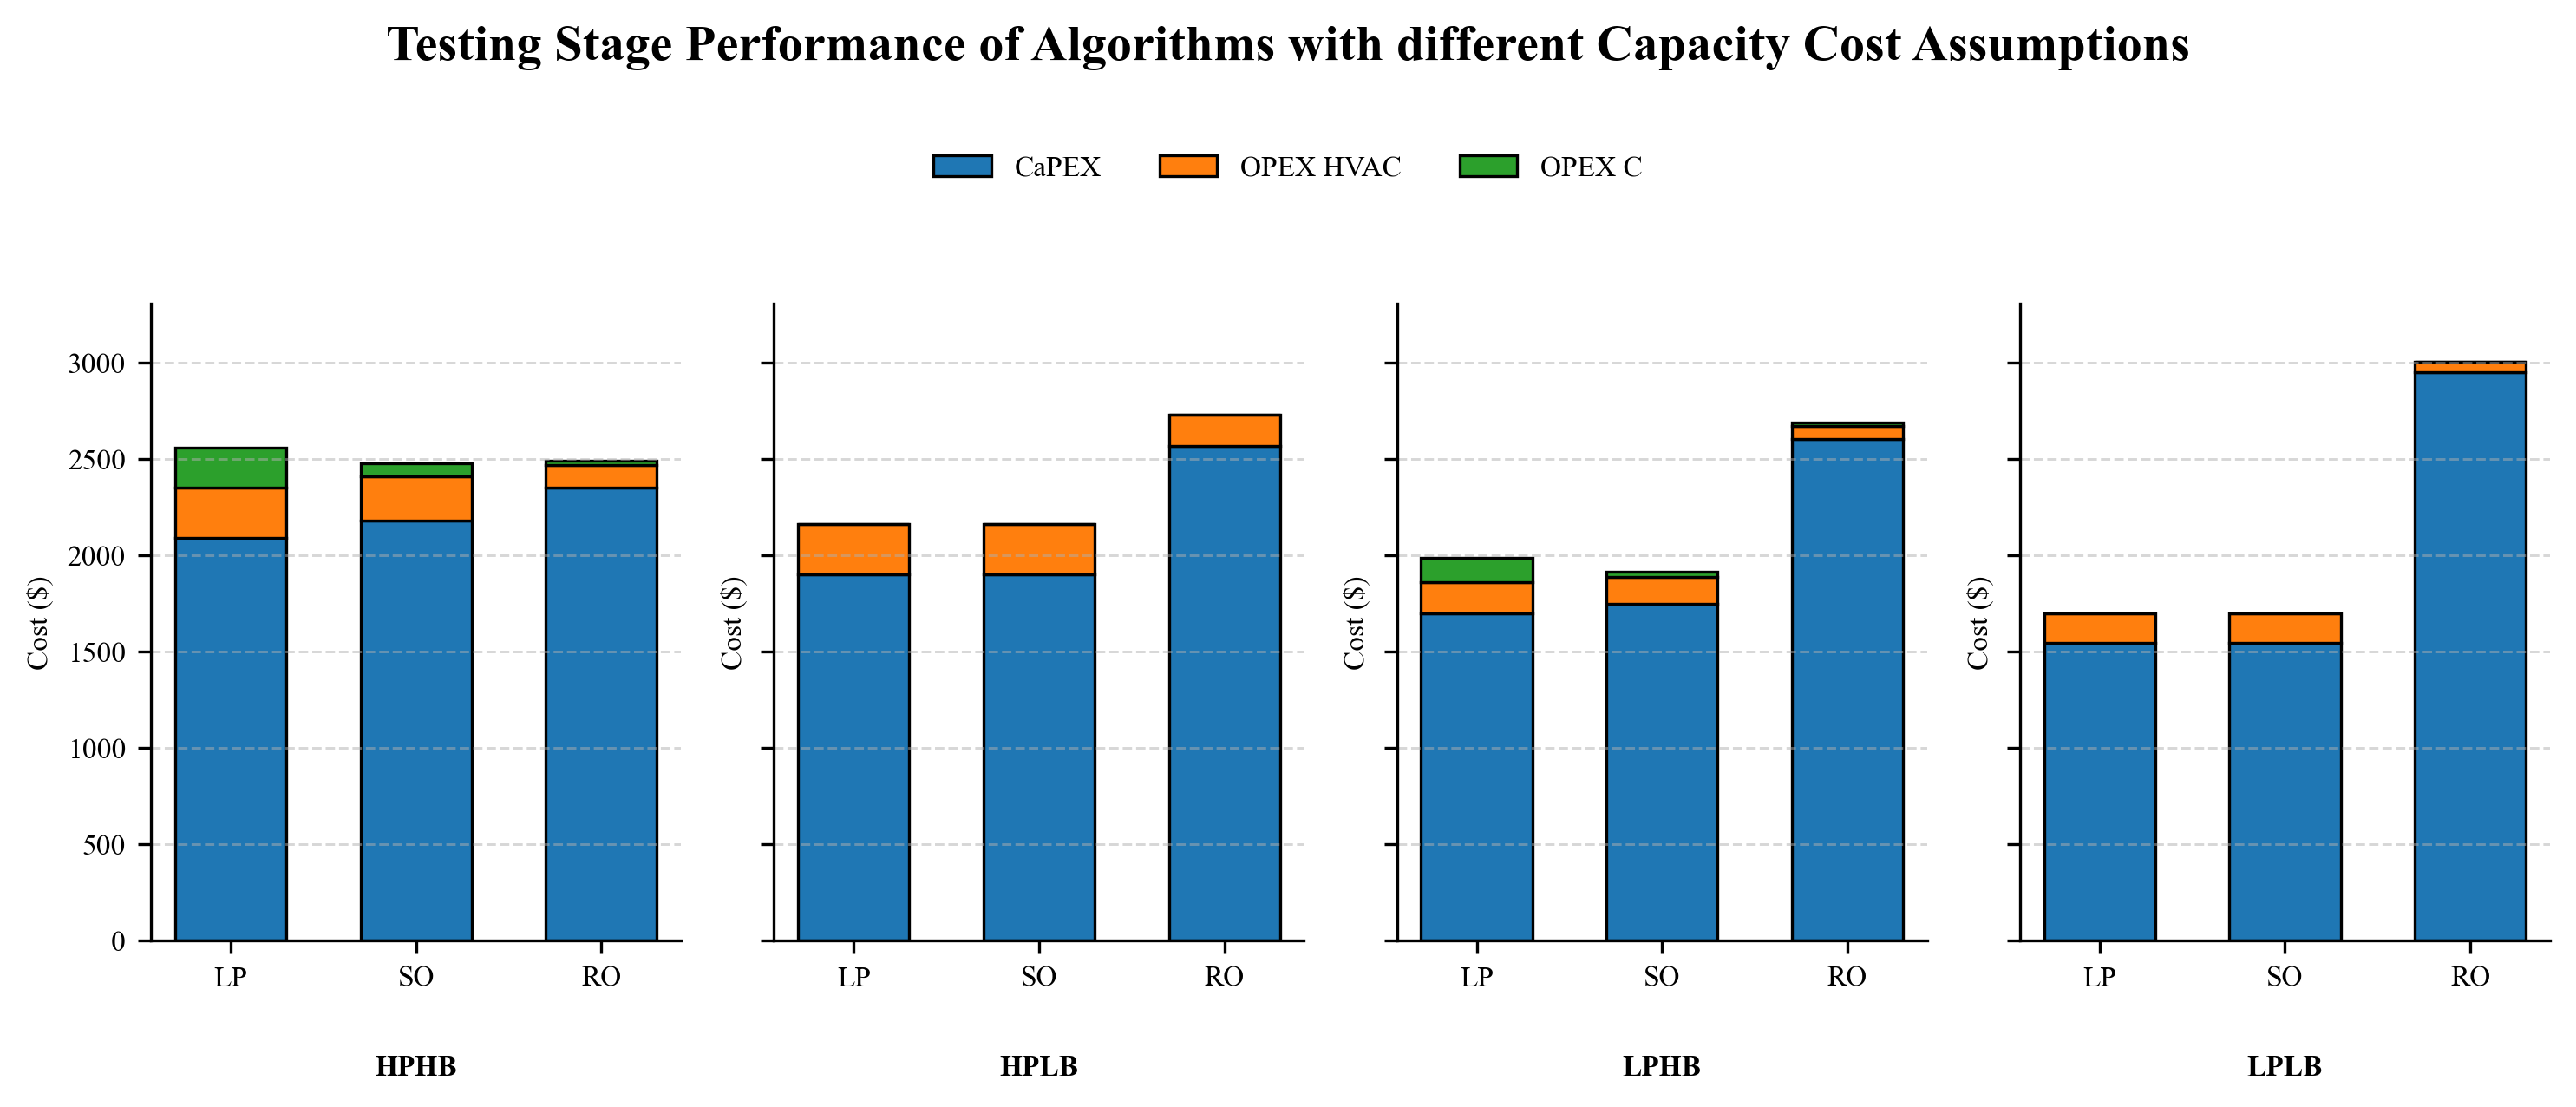

C:\Users\Fred\AppData\Local\Temp\ipykernel_14124\2231171250.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


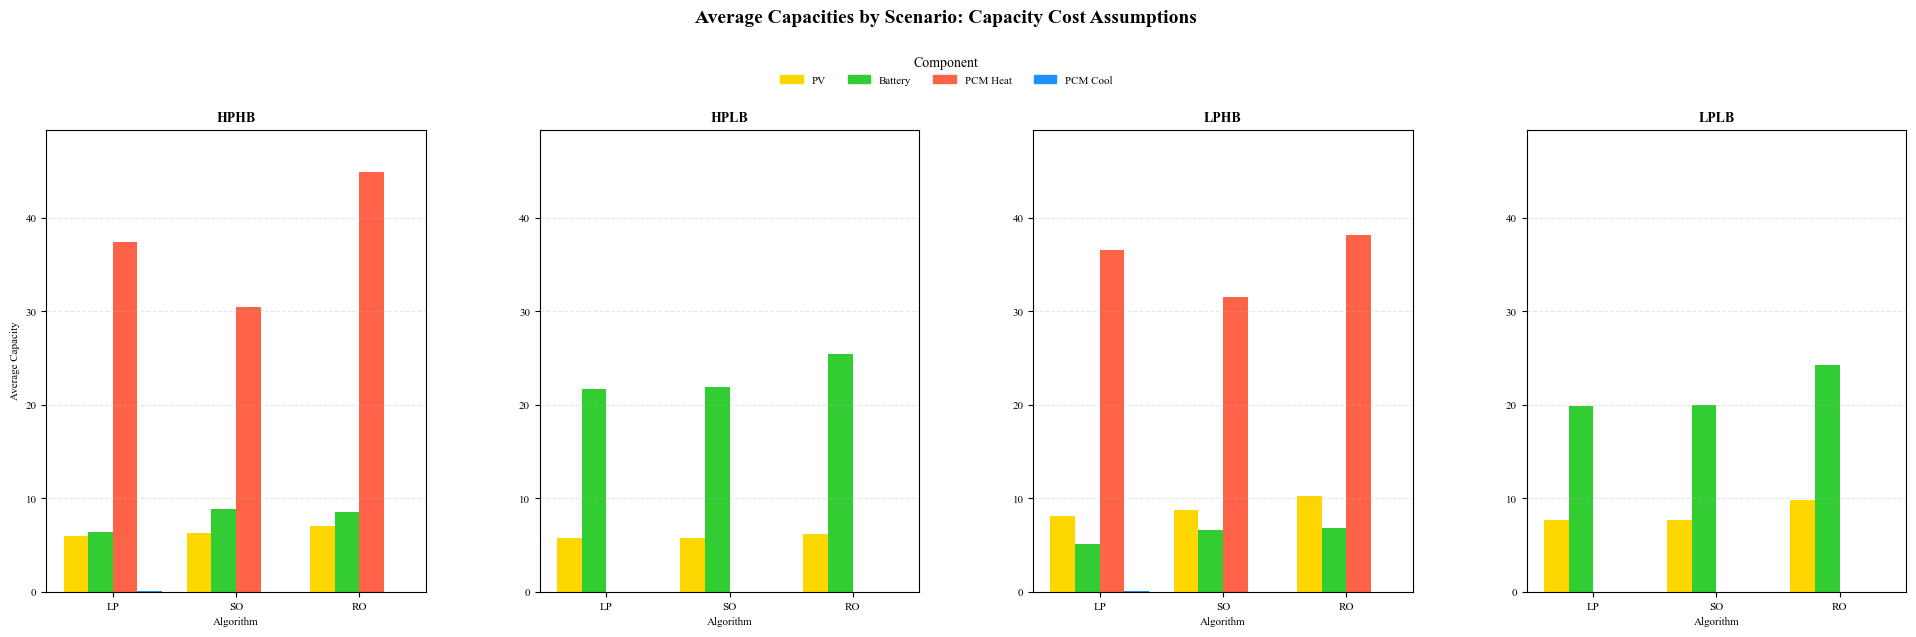

In [17]:
SA_name = 'Capacity_Costs'

# Example usage for Locations:
cap_cost_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)
# Old capacity box plot unused
# capacity_box_plot(cap_cost_data, SA_name, "Capacity Cost Assumptions")

# capacity bar plot
# Run the plotting function
plot_grouped_stacked_bars_ieee_cap_cost(cap_cost_data, SA_name, "Capacity Cost Assumptions")

special_scenarios = []
scenario_capacity_barplot(cap_cost_data, SA_name, "Capacity Cost Assumptions", special_scenarios)

In [53]:
from matplotlib.patches import Rectangle

def prepare_scatter_data(data_dict, category_name):
    """Convert nested dictionary to DataFrame with category label"""
    scatter_data = []
    
    for sub_category, folds in data_dict.items():
        for fold_num, df in folds.items():
            for _, row in df.iterrows():
                scatter_data.append({
                    'Category': category_name,
                    'SubCategory': sub_category,
                    'Fold': fold_num,
                    'Algorithm': row['Algorithm'],
                    'CaPEX': row['Training Capital Cost'],
                    'OPEX': row['Testing HVAC Cost'] + row['Testing Critical Load Cost']
                })
    return pd.DataFrame(scatter_data)

all_data = pd.concat([
    prepare_scatter_data(location_data, 'Locations'),
    prepare_scatter_data(cap_cost_data, 'Capacity Costs'),
    prepare_scatter_data(scenario_data, 'Scenarios')
])

In [70]:
def scatter_faceted_by_category_with_ols(
    all_data,
    category_order=['Locations', 'Scenarios', 'Capacity Costs'],
    algorithm_colors={'LP': '#1f77b4', 'SO': '#ff7f0e', 'RO': '#2ca02c'},
    marker_styles=None
):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl
    import statsmodels.api as sm

    # Set IEEE style
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 14

    # Most distinctive matplotlib markers
    base_markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '>', '<']

    n_cats = len(category_order)
    fig, axes = plt.subplots(1, n_cats, figsize=(5*n_cats + 2, 4), dpi=300, sharey=False)
    if n_cats == 1:
        axes = [axes]

    from matplotlib.lines import Line2D

    for idx, category in enumerate(category_order):
        ax = axes[idx]
        cat_data = all_data[all_data['Category'] == category]
        subcats_in_panel = sorted(cat_data['SubCategory'].unique())
        # Assign markers per panel
        panel_marker_styles = {subcat: base_markers[i % len(base_markers)] for i, subcat in enumerate(subcats_in_panel)}
        # Plot each subcategory with its marker
        for subcat in subcats_in_panel:
            subcat_data = cat_data[cat_data['SubCategory'] == subcat]
            for alg, color in algorithm_colors.items():
                alg_data = subcat_data[subcat_data['Algorithm'] == alg]
                if not alg_data.empty:
                    ax.scatter(
                        alg_data['CaPEX'], alg_data['OPEX'],
                        color=color,
                        marker=panel_marker_styles[subcat],
                        label=f"{alg}-{subcat}",
                        edgecolor='w', linewidth=0.7, s=70, alpha=0.9
                    )
        # OLS fit for each algorithm
        for alg, color in algorithm_colors.items():
            alg_data = cat_data[cat_data['Algorithm'] == alg]
            if len(alg_data) > 1:
                X = alg_data['CaPEX']
                Y = alg_data['OPEX']
                X_ = sm.add_constant(X)
                model = sm.OLS(Y, X_).fit()
                x_pred = np.linspace(X.min(), X.max(), 100)
                y_pred = model.predict(sm.add_constant(x_pred))
                ax.plot(x_pred, y_pred, color=color, linewidth=2, alpha=0.8, linestyle='dashdot', label=f"{alg} OLS")
        ax.set_xlabel('CaPEX ($)', fontsize=8)
        if idx == 0:
            ax.set_ylabel('OPEX ($)', fontsize=8)
        ax.set_title(category, fontsize=10, fontweight='bold')
        ax.grid(axis='both', linestyle='--', alpha=0.5, linewidth=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Subcategory legend for this panel, outside the plot
        marker_legend = [Line2D([0], [0], marker=panel_marker_styles[subcat], color='gray', label=subcat,
                                markerfacecolor='gray', markersize=10, linestyle='None')
                         for subcat in subcats_in_panel]
        ax.legend(handles=marker_legend, title='SubCategory', loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8, frameon=False)

    # Global algorithm legend (color)
    color_legend = [Line2D([0], [0], marker='o', color='w', label=alg,
                           markerfacecolor=color, markersize=8)
                    for alg, color in algorithm_colors.items()]
    fig.legend(handles=color_legend, title='Algorithm', loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=len(algorithm_colors), fontsize=8, frameon=False)

    plt.suptitle('CaPEX vs OPEX by Category, Algorithm, and SubCategory', y=1.08, fontsize=14, fontweight='bold', fontname='Times New Roman')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

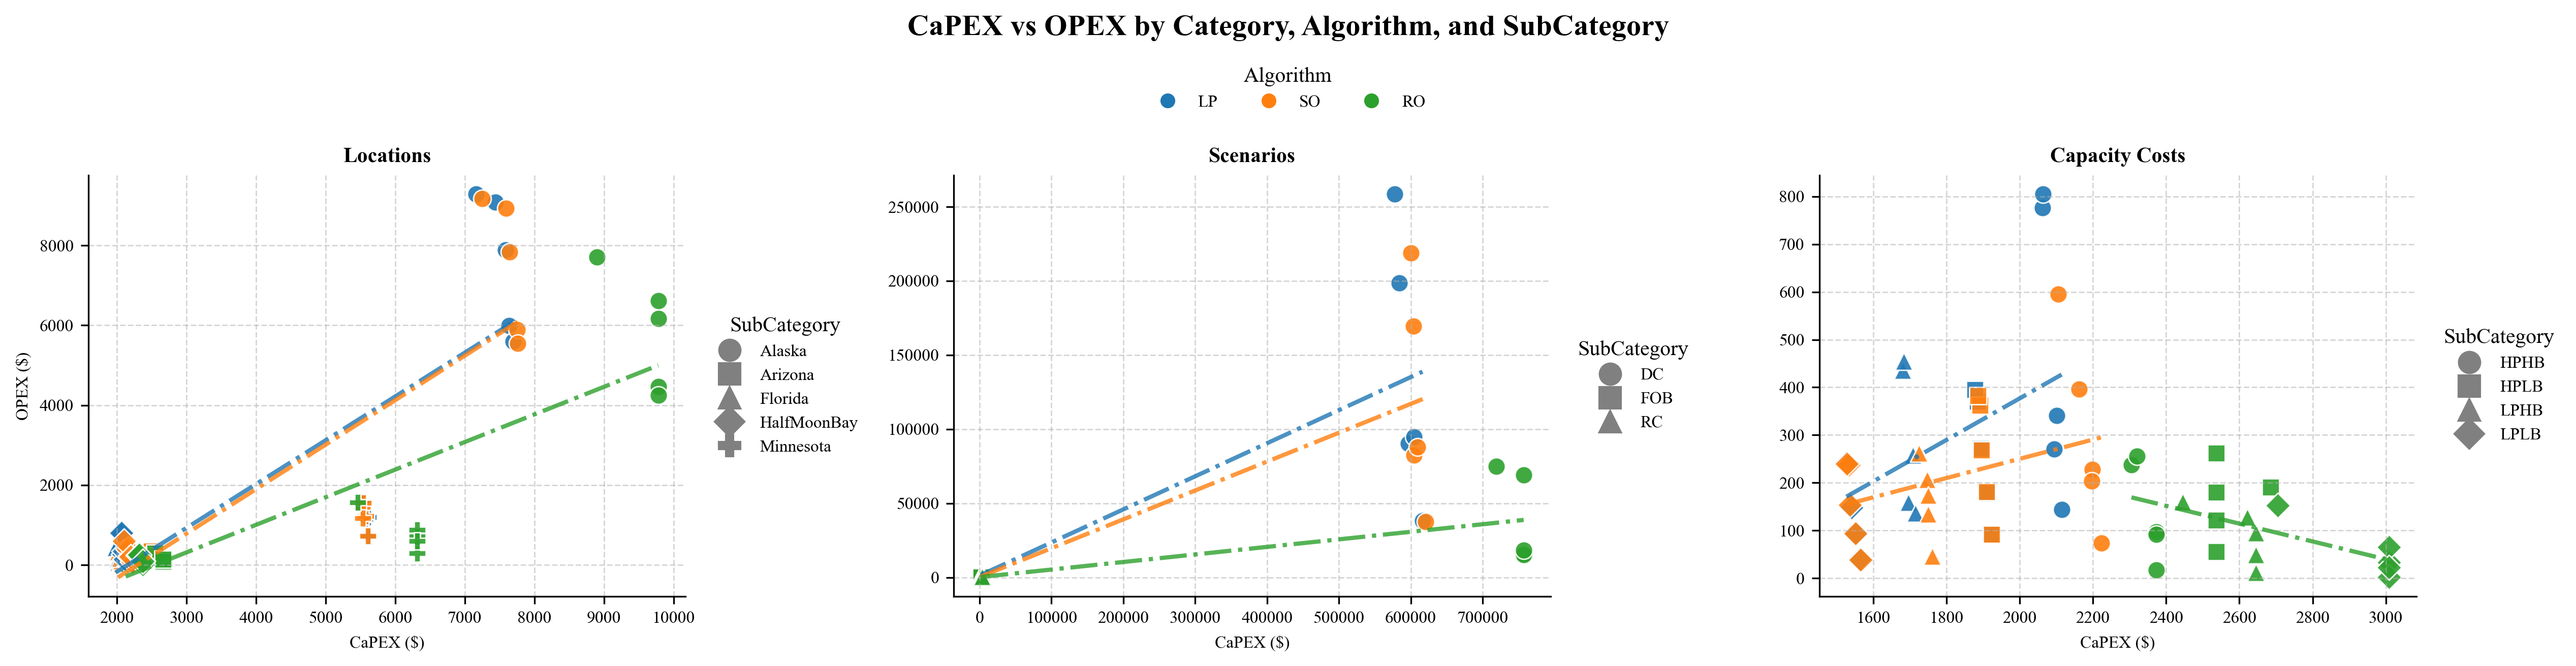

In [71]:
scatter_faceted_by_category_with_ols(all_data)

## Load Yearly Data

In [10]:
def load_yearly_data_nested(folder_name, file_name):
    """
    Load location data into nested dictionary structure:
    location_data_yr[location][year][variable] = value
    
    Args:
        folder_name: Name of the folder containing the file
        file_name: Name of the Excel file
        
    Returns:
        Nested dictionary {location: {year: {variable: value}}}
    """
    file_path = os.path.join(folder_name, file_name)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    try:
        all_sheets = pd.read_excel(file_path, sheet_name=None)
    except Exception as e:
        raise ValueError(f"Error reading Excel file: {str(e)}")
    
    location_data_yr = {}
    
    for sheet_name, df in all_sheets.items():
        # Initialize location dictionary
        location_data_yr[sheet_name] = {}
        
        # Convert Year column to integer
        df['Year'] = df['Year'].astype(int)
        
        # Iterate through each row (year) in the sheet
        for _, row in df.iterrows():
            year = row['Year']
            location_data_yr[sheet_name][year] = {
                'var PV': row['var PV'],
                'var E_Load': row['var E_Load'],
                'var Cooling_Load': row['var Cooling_Load'],
                'var Heating_Load': row['var Heating_Load'],
                'CV PV': row['CV PV'],
                'CV E_Load': row['CV E_Load'],
                'CV Cooling_Load': row['CV Cooling_Load'],
                'CV Heating_Load': row['CV Heating_Load'],
                'Total pv (kWh/kW Capacity)': row['Total pv (kWh/kW Capacity)'],
                'Total E_Load (kWh)': row['Total E_Load (kWh)'],
                'Total Cooling_Load (kWh T)': row['Total Cooling_Load (kWh T)'],
                'Total Heating_Load (kWh T)': row['Total Heating_Load (kWh T)']
            }
    
    return location_data_yr

In [11]:
location_data_yr = load_yearly_data_nested("Yearly_Results", "locations_result.xlsx")
scenario_data_yr = load_yearly_data_nested("Yearly_Results", "scenarios_result.xlsx")

fold = 5
weather_year_list = list(range(1998, 2023))  # 1998-2022 (25 years total)
algorithms = ["LP", "SO", "RO"]

## Calculate cost per energy served for Locations Sensivity Run

In [12]:
# Initialize the dictionary properly
cost_per_energy_served_loc = {}

for loc in location_data_yr.keys():  # Added parentheses for .keys() method
    # Initialize location in dictionary
    cost_per_energy_served_loc[loc] = {}
    
    for k in range(fold):
        # Initialize fold in dictionary
        cost_per_energy_served_loc[loc][k] = {}
        
        # Get testing years (5-year chunks)
        start_idx = k * 5
        testing_year_list = weather_year_list[start_idx : start_idx + 5]
        training_year_list = [y for y in weather_year_list if y not in testing_year_list]
        
        # Get the fold data
        df = location_data[loc][f'Fold_{k+1}']  # Assuming folds are numbered 1-5
        
        for algo in algorithms:
            # Extract algorithm-specific costs
            algo_df = df[df['Algorithm'] == algo]
            if len(algo_df) == 0:
                continue  # Skip if no data for this algorithm
                
            capital_cost = algo_df['Testing Capital Cost'].values[0]
            critical_load_cost = algo_df['Testing Critical Load Cost'].values[0]
            hvac_cost = algo_df['Testing HVAC Cost'].values[0]
            
            # Calculate energy sums
            total_e_load = np.sum([location_data_yr[loc][yr]["Total E_Load (kWh)"] for yr in testing_year_list])
            total_thermal_load = np.sum([
                location_data_yr[loc][yr]["Total Cooling_Load (kWh T)"] + 
                location_data_yr[loc][yr]["Total Heating_Load (kWh T)"]
                for yr in testing_year_list
            ])
            
            # Calculate cost per energy served
            numerator = capital_cost
            denominator = (
                (total_e_load/5 - critical_load_cost/300) + 
                (total_thermal_load/5 - hvac_cost/3)
            )
            
            # Avoid division by zero
            if denominator <= 0:
                cost_per_energy_served_loc[loc][k][algo] = None  # or np.nan
            else:
                cost_per_energy_served_loc[loc][k][algo] = numerator / denominator

## Calculate cost per energy served for Capacity Cost Assumption Sensivity Run

In [13]:
# Initialize the dictionary properly
cost_per_energy_served_cap = {}

caps = ["HPHB", "HPLB", "LPHB", "LPLB"]

for cap in caps: 
    # Initialize location in dictionary
    cost_per_energy_served_cap[cap] = {}
    
    for k in range(fold):
        # Initialize fold in dictionary
        cost_per_energy_served_cap[cap][k] = {}
        
        # Get testing years (5-year chunks)
        start_idx = k * 5
        testing_year_list = weather_year_list[start_idx : start_idx + 5]
        training_year_list = [y for y in weather_year_list if y not in testing_year_list]
        
        # Get the fold data
        df = cap_cost_data[cap][f'Fold_{k+1}']  # Assuming folds are numbered 1-5
        
        for algo in algorithms:
            # Extract algorithm-specific costs
            algo_df = df[df['Algorithm'] == algo]
            if len(algo_df) == 0:
                continue  # Skip if no data for this algorithm
                
            capital_cost = algo_df['Testing Capital Cost'].values[0]
            critical_load_cost = algo_df['Testing Critical Load Cost'].values[0]
            hvac_cost = algo_df['Testing HVAC Cost'].values[0]
            
            # Calculate energy sums
            total_e_load = np.sum([location_data_yr["HalfMoonBay"][yr]["Total E_Load (kWh)"] for yr in testing_year_list])
            total_thermal_load = np.sum([
                location_data_yr["HalfMoonBay"][yr]["Total Cooling_Load (kWh T)"] + 
                location_data_yr["HalfMoonBay"][yr]["Total Heating_Load (kWh T)"]
                for yr in testing_year_list
            ])
            
            # Calculate cost per energy served
            numerator = capital_cost
            denominator = (
                (total_e_load/5 - critical_load_cost/300) + 
                (total_thermal_load/5 - hvac_cost/3)
            )
            
            # Avoid division by zero
            if denominator <= 0:
                cost_per_energy_served_cap[cap][k][algo] = None  # or np.nan
            else:
                cost_per_energy_served_cap[cap][k][algo] = numerator / denominator


## Calculate cost per energy served for Scenario Sensivity Run

In [14]:
# Initialize the dictionary properly
cost_per_energy_served_sce = {}

sces = ["FOB", "DC", "RC"]

for sce in sces: 
    # Initialize location in dictionary
    cost_per_energy_served_sce[sce] = {}
    
    for k in range(fold):
        # Initialize fold in dictionary
        cost_per_energy_served_sce[sce][k] = {}
        
        # Get testing years (5-year chunks)
        start_idx = k * 5
        testing_year_list = weather_year_list[start_idx : start_idx + 5]
        training_year_list = [y for y in weather_year_list if y not in testing_year_list]
        
        # Get the fold data
        df = scenario_data[sce][f'Fold_{k+1}']  # Assuming folds are numbered 1-5
        
        for algo in algorithms:
            # Extract algorithm-specific costs
            algo_df = df[df['Algorithm'] == algo]
            if len(algo_df) == 0:
                continue  # Skip if no data for this algorithm
                
            capital_cost = algo_df['Testing Capital Cost'].values[0]
            critical_load_cost = algo_df['Testing Critical Load Cost'].values[0]
            hvac_cost = algo_df['Testing HVAC Cost'].values[0]
            
            # Calculate energy sums
            total_e_load = np.sum([scenario_data_yr[sce][yr]["Total E_Load (kWh)"] for yr in testing_year_list])
            total_thermal_load = np.sum([
                scenario_data_yr[sce][yr]["Total Cooling_Load (kWh T)"] + 
                scenario_data_yr[sce][yr]["Total Heating_Load (kWh T)"]
                for yr in testing_year_list
            ])
            
            # Calculate cost per energy served
            numerator = capital_cost
            if sce == 'DC':            
                denominator = (
                    (total_e_load/5 - critical_load_cost/30) + 
                    (total_thermal_load/5 - hvac_cost/10)
                )
            else:
                denominator = (
                    (total_e_load/5 - critical_load_cost/300) + 
                    (total_thermal_load/5 - hvac_cost/3)
                )
                
            # Avoid division by zero
            if denominator <= 0:
                cost_per_energy_served_sce[sce][k][algo] = None  # or np.nan
            else:
                cost_per_energy_served_sce[sce][k][algo] = numerator / denominator

## This following plot function uses same y-axis scale (unused, but maybe we should use this)

In [15]:
# def plot_cost_per_energy_boxplots(cost_per_energy_served_loc, SA_name):
#     """
#     Create box plots of cost per energy served for each location, with algorithms compared.
#     All subplots share the same y-axis scale for fair comparison.
    
#     Args:
#         cost_per_energy_served_loc: Dictionary with structure {loc: {fold: {algo: value}}}
#         SA_name: String for the sensitivity analysis dimension (e.g., "Locations", "Scenarios")
#     """
#     # Convert dictionary to DataFrame for easier plotting
#     plot_data = []
#     for loc in cost_per_energy_served_loc:
#         for fold in cost_per_energy_served_loc[loc]:
#             for algo in cost_per_energy_served_loc[loc][fold]:
#                 value = cost_per_energy_served_loc[loc][fold][algo]
#                 if value is not None:  # Skip None values
#                     plot_data.append({
#                         SA_name: loc,
#                         'Fold': fold,
#                         'Algorithm': algo,
#                         'Cost per Energy Served': value
#                     })
    
#     df = pd.DataFrame(plot_data)
    
#     # Calculate global y-axis limits
#     y_min = df['Cost per Energy Served'].min() * 0.9  # 10% padding
#     y_max = df['Cost per Energy Served'].max() * 1.1  # 10% padding
    
#     # Create figure with subplots
#     locations = sorted(df[SA_name].unique())
#     n_locations = len(locations)
#     fig, axes = plt.subplots(1, n_locations, figsize=(4*n_locations, 6), sharey=True)
    
#     # If only one location, make axes a list for consistent handling
#     if n_locations == 1:
#         axes = [axes]
    
#     # Define colors for each algorithm
#     algo_colors = {
#         'LP': '#1f77b4',  # Blue
#         'SO': '#ff7f0e',  # Orange
#         'RO': '#2ca02c'   # Green
#     }
    
#     # Plot each location
#     for ax, loc in zip(axes, locations):
#         loc_data = df[df[SA_name] == loc]
        
#         # Prepare data for boxplot
#         box_data = []
#         for algo in ['LP', 'SO', 'RO']:
#             algo_data = loc_data[loc_data['Algorithm'] == algo]['Cost per Energy Served']
#             box_data.append(algo_data.dropna().values)  # Remove NaN values
        
#         # Create boxplot
#         box = ax.boxplot(box_data, patch_artist=True, widths=0.6)
        
#         # Customize median lines
#         for median in box['medians']:
#             median.set(color='black', linewidth=2)
        
#         # Color the boxes
#         for patch, algo in zip(box['boxes'], ['LP', 'SO', 'RO']):
#             patch.set_facecolor(algo_colors[algo])
        
#         # Customize plot
#         ax.set_title(loc)
#         ax.set_xticks([1, 2, 3])
#         ax.set_xticklabels(['LP', 'SO', 'RO'])
#         ax.set_ylabel('Cost per Energy Served [$/kWh]')
#         ax.grid(True, linestyle='--', alpha=0.3)
#         ax.set_ylim(y_min, y_max)  # Set consistent y-limits
        
#         # Only show y-label for first subplot
#         if ax != axes[0]:
#             ax.set_ylabel('')
    
#     # Add legend
#     handles = [plt.Rectangle((0,0),1,1, color=algo_colors[algo]) 
#                for algo in ['LP', 'SO', 'RO']]
#     fig.legend(handles, ['LP', 'SO', 'RO'], 
#               title='Algorithm', loc='upper right', bbox_to_anchor=(1.15, 0.8))
    
#     plt.suptitle(f'Cost per Energy Served by {SA_name} and Algorithm', y=1.05, fontsize=12)
#     plt.tight_layout()
#     plt.show()

## This following function has different y-axis scale for subplots

In [76]:
def plot_cost_per_energy_boxplots(cost_per_energy_served_loc, SA_name):
    """
    Create box plots of cost per energy served for each location, with algorithms compared.
    Args:
        cost_per_energy_served_loc: Dictionary with structure {loc: {fold: {algo: value}}}
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl
    import pandas as pd

    # Set IEEE-compliant font and style globally
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 14

    # Convert dictionary to DataFrame for easier plotting
    plot_data = []
    for loc in cost_per_energy_served_loc:
        for fold in cost_per_energy_served_loc[loc]:
            for algo in cost_per_energy_served_loc[loc][fold]:
                value = cost_per_energy_served_loc[loc][fold][algo]
                if value is not None:  # Skip None values
                    plot_data.append({
                        SA_name: loc,
                        'Fold': fold,
                        'Algorithm': algo,
                        'Cost per Energy Served': value
                    })
    df = pd.DataFrame(plot_data)

    # Create figure with subplots
    locations = sorted(df[SA_name].unique())
    n_locations = len(locations)
    fig, axes = plt.subplots(1, n_locations, figsize=(4*n_locations, 6), sharey=True)

    # If only one location, make axes a list for consistent handling
    if n_locations == 1:
        axes = [axes]

    # Define colors for each algorithm
    algo_colors = {
        'LP': '#1f77b4',  # Blue
        'SO': '#ff7f0e',  # Orange
        'RO': '#2ca02c'   # Green
    }

    # Find global y-limits for all boxplots
    y_min, y_max = np.inf, -np.inf
    for loc in locations:
        loc_data = df[df[SA_name] == loc]
        for algo in ['LP', 'SO', 'RO']:
            algo_data = loc_data[loc_data['Algorithm'] == algo]['Cost per Energy Served']
            if not algo_data.empty:
                y_min = min(y_min, algo_data.min())
                y_max = max(y_max, algo_data.max())
    y_margin = 0.05 * (y_max - y_min)
    y_limits = (y_min - y_margin, y_max + y_margin)

    # Plot each location
    for ax, loc in zip(axes, locations):
        loc_data = df[df[SA_name] == loc]
        # Prepare data for boxplot
        box_data = []
        for algo in ['LP', 'SO', 'RO']:
            algo_data = loc_data[loc_data['Algorithm'] == algo]['Cost per Energy Served']
            box_data.append(algo_data.dropna().values)  # Remove NaN values

        # Create boxplot
        box = ax.boxplot(box_data, patch_artist=True, widths=0.6)

        # To modify the median line:
        for median in box['medians']:
            median.set(color='black', linewidth=2)
        # Color the boxes
        for patch, algo in zip(box['boxes'], ['LP', 'SO', 'RO']):
            patch.set_facecolor(algo_colors[algo])

        # Customize plot
        ax.set_title(loc, fontsize=10, fontweight='bold')
        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels(['LP', 'SO', 'RO'])
        ax.set_ylabel('Cost per Energy Served [$/kWh]' if ax == axes[0] else '', fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_ylim(y_limits)

    # Add legend (centered at the top, under suptitle)
    handles = [plt.Rectangle((0,0),1,1, color=algo_colors[algo]) 
               for algo in ['LP', 'SO', 'RO']]
    fig.legend(handles, ['LP', 'SO', 'RO'], 
               title='Algorithm', loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=8, frameon=False)

    plt.suptitle(f'Cost per Energy Served by {SA_name} and Algorithm', y=1.08, fontsize=14, fontweight='bold', fontname='Times New Roman')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

## Plot Cost per Energy Served Plots

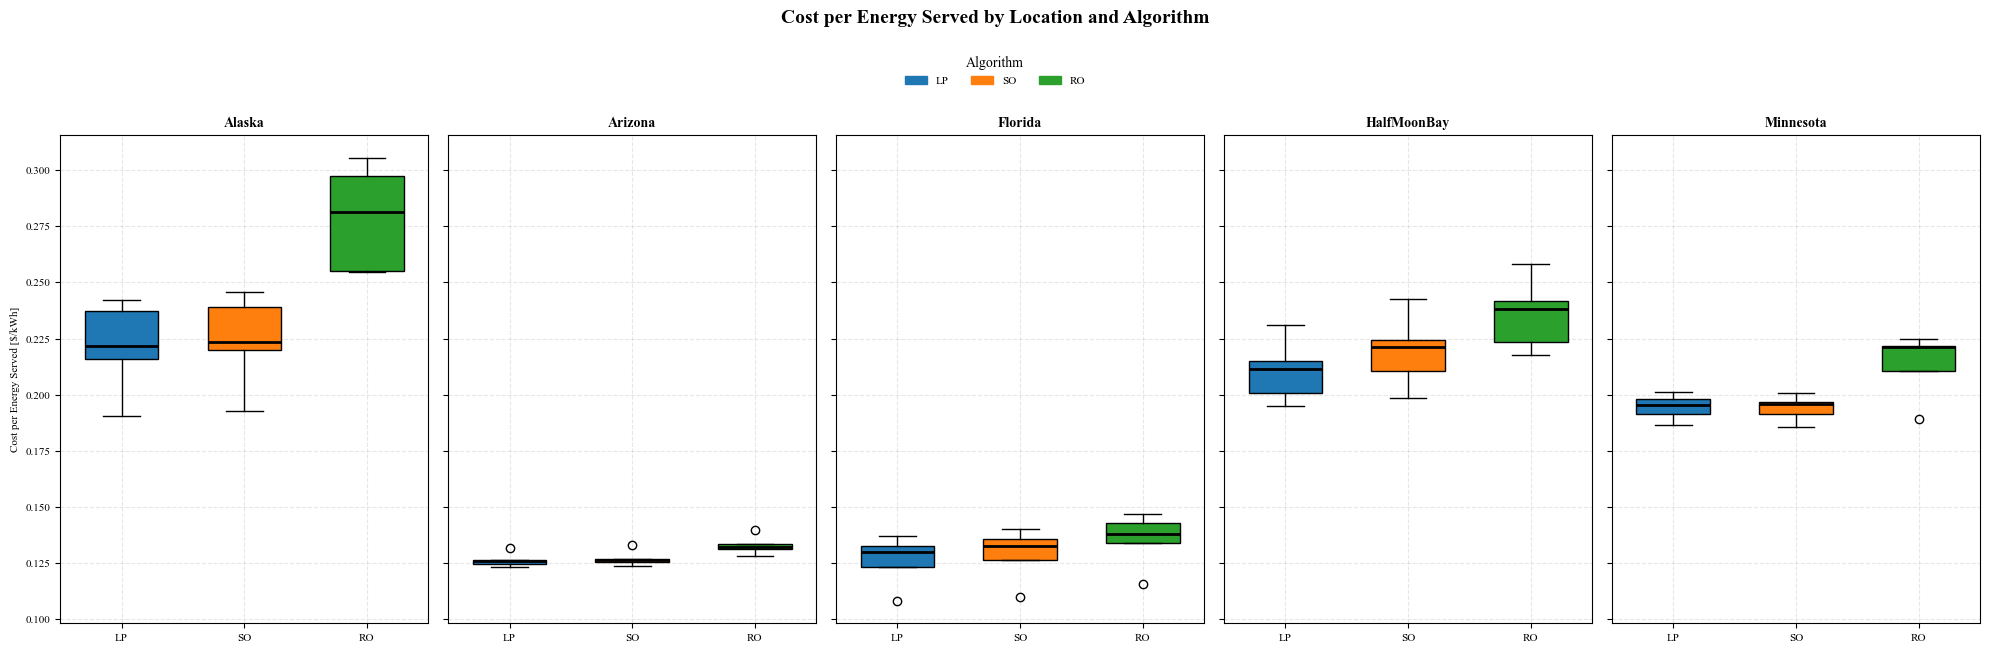

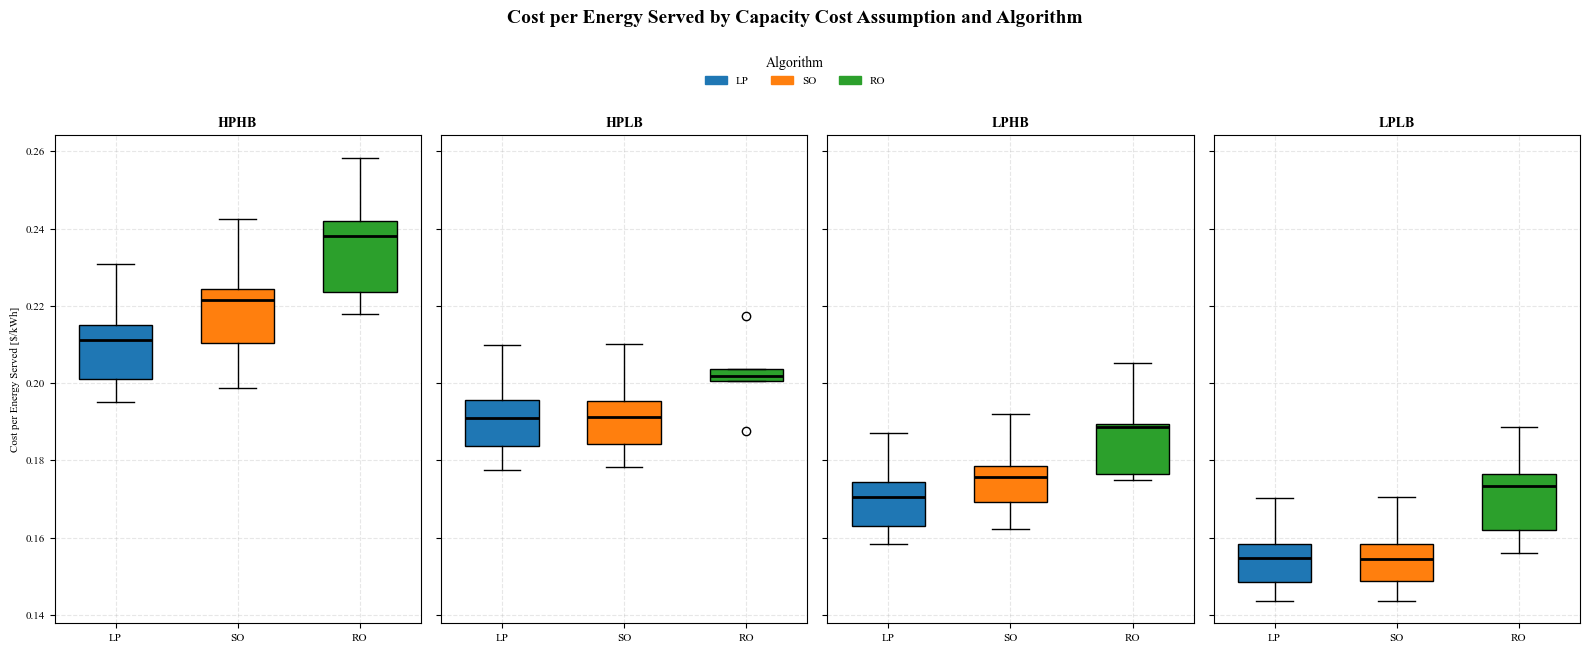

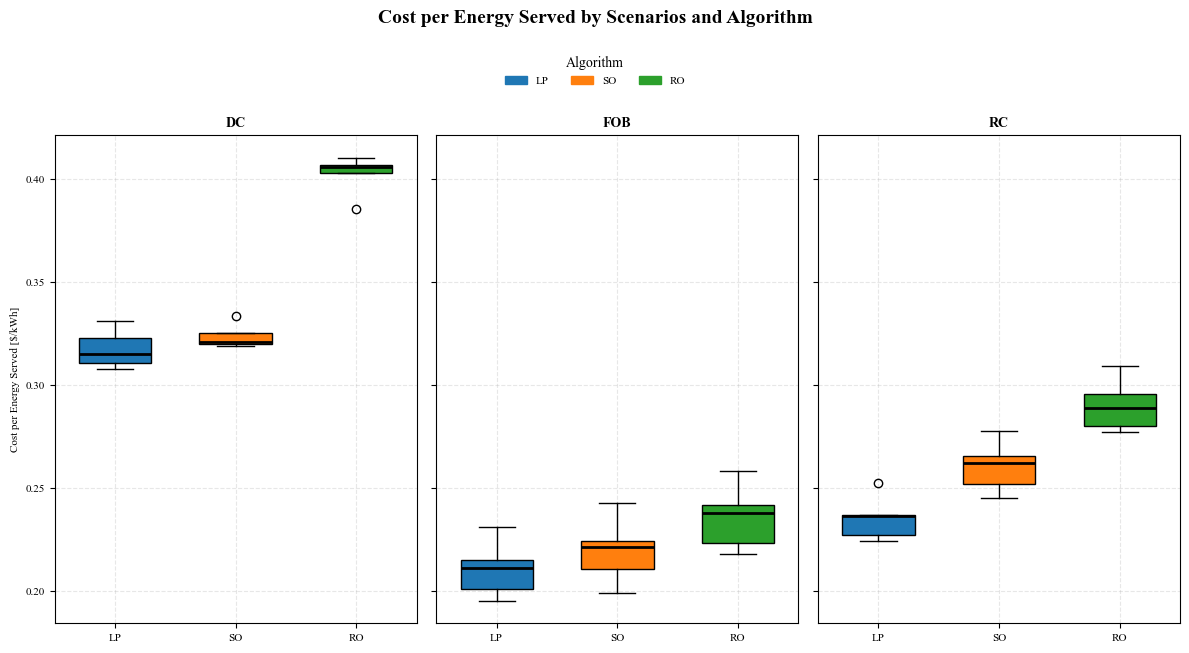

In [77]:

plot_cost_per_energy_boxplots(cost_per_energy_served_loc, 'Location')
plot_cost_per_energy_boxplots(cost_per_energy_served_cap, 'Capacity Cost Assumption')
plot_cost_per_energy_boxplots(cost_per_energy_served_sce, 'Scenarios')